## КЛАСТЕРНЫЙ АНАЛИЗ ГЕОГРАФИЧЕСКО-ЭКОНОМИЧЕСКИХ ПОКАЗАТЕЛЕЙ МИКРОРАЙОНОВ ГОРОДА ВЛАДИВОСТОК

**`Цель`**: На основе анализа различных характеристик микрорайонов Владивостока он может быть разбит на группы и исследование сложной системы может быть сведено к изучению ограниченного числа групп, а по средним значениям показателей в каждой группе появляется возможность их сравнивать, выявлять различия и тенденции изменения. В связи с этим необходимо найти сравнительно однородные группы микрорайонов  схожие по основным характеристикам.

Для кластерного анализы выбраны следующие 12 показателей по каждому микрорайону:
1.	rooms – медианное количество комнат в квартирах микрорайона;
2.	floor – медианное значение этажа квартир микрорайона;
3.	floors_in_house – этажность домов микрорайона;
4.	keep – тип ремонта в квартире:   
5.	balcon – наличие балкона:  
6.	building_year – год постройки домов;
7.	wall_id – материал стен домов:
8.	bath – тип санузла:
9.	dist_centr – расстояние до центра города, в км;
10.	 priceM – средняя цена по району;
11.	 area – площадь района, км2;
12.	 sea – наличие морского побережья в микрорайоне.

## Оглавление

1. [Предварительная обработка данных](#1)<br>
    1.1. [Масштабирование данных между 0 и 1](#1.1)<br>
    1.2. [Уменьшение размерности данных с помощью метода главных компонент](#1.2)<br>
2. [Кластерный анализ с помощью иерархического метода](#2)<br>
3. [Кластерный анализ с помощью алгоритма k-means](#3)<br>
    3.1. [Выбор оптимального числа кластеров](#3.1)<br>
    3.2. [Использование алгоритма k-средних](#3.2)<br>
4. [Вывод](#4)<br>

In [1]:
# Импортируем библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn import metrics 
plt.style.use('seaborn-whitegrid')
%config InlineBackend.figure_format = 'svg'
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_excel('data_for_CA.xlsx', index_col=0)

In [3]:
df.head()

,rooms,floor,floors_in_house,building_year,wall_id,dist_centr,keepLabel,balconLabel,bathLabel,priceM,area,sea
districttr,,,,,,,,,,,,
"64, 71 микрорайоны",2.0,8.0,17.0,2017.0,15.0,6,2,1,1.0,154163.0,7.494899,0
БАМ,2.0,5.0,9.0,1982.0,12.0,6,2,1,1.0,154389.0,4.570670,0
Баляева,2.0,4.0,9.0,1981.0,12.0,5,2,1,1.0,150306.0,2.582426,0
Борисенко,2.0,4.0,9.0,1985.0,12.0,6,2,1,1.0,132244.0,2.683238,0
Весенняя,2.0,1.0,4.0,2021.0,11.5,24,0,1,0.5,114877.0,9.637321,1


## 1. Предварительная обработка данных <a class="anchor" id="1"></a>

### 1.1 Масштабирование данных между 0 и 1 <a class="anchor" id="1.1"></a>

In [4]:
def scaler(data):
    scaler = preprocessing.MinMaxScaler()

    names = data.columns
    index = list(data.index)
    d_MinMaxScaler = scaler.fit_transform(data)

    data = pd.DataFrame(d_MinMaxScaler, columns=names)
    data.index = index
    return data

In [5]:
data = scaler(df)

In [6]:
data.shape

(29, 12)

### 1.2. Уменьшение размерности данных с помощью метода главных компонент <a class="anchor" id="1.2"></a>

Так как переменных достаточно много и больше, чем объектов, необходимо снизить размерность признакового пространства с помощью метода главных компонент. На первом этапе необходимо оценить количество компонент, необходимых для описания данных. Определить их можно с помощью представления интегральной доли объяснимой дисперсии в виде функции от количества компонент, представленной на графике. 


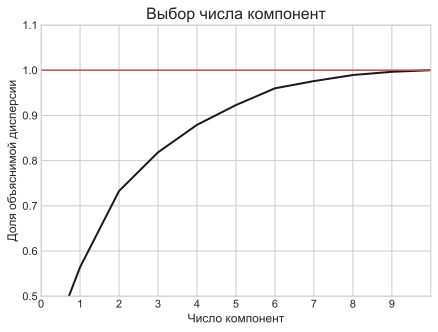

In [7]:
pca = PCA().fit(data)
plt.figure(figsize=(7,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='k', lw=2)
plt.title("Выбор числа компонент", fontsize = 16)
plt.xlabel('Число компонент', fontsize = 12)
plt.ylabel('Доля объяснимой дисперсии', fontsize = 12)
plt.xlim(0, 10)
plt.ylim(0.7,1.1)
plt.xticks(range(0,10))
plt.yticks(np.arange(0.5, 1.2, 0.1))
plt.axvline(12, c='b')
plt.axhline(1, c='r')
plt.show();

Из рисунка видно, что в первые 5 компонент содержат примерно 93% дисперсии, а для описания близкой к 100% доли дисперсии необходимо 8 компонент. Оставим 5 компонент вместо 12 признаков, трансформируем переменную data и в переменную data_pca запишем значения новых признаков.

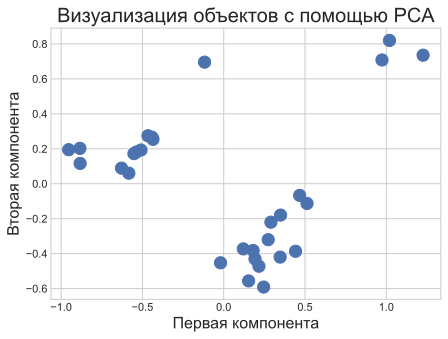

In [8]:
pca = PCA(n_components = 5, random_state = 20)
data_pca = pca.fit_transform(data)
plt.figure(figsize = (7, 5))
plt.scatter(data_pca[:, 0], data_pca[:, 2], s =150)
plt.xlabel('Первая компонента', fontsize = 16)
plt.ylabel('Вторая компонента', fontsize = 16)
plt.title('Визуализация объектов с помощью PCA', fontsize = 20);

In [9]:
data_pca = pd.DataFrame(data_pca, index=data.index, columns=['comp_1','comp_2','comp_3','comp_4','comp_5'])

## Кластерный анализ с помощью иерархического метода <a class="anchor" id="2"></a>

In [10]:
# Функция для построения дендограммы
def create_dendrogram(data,method='ward',metric='euclidean'):
    samples = data.values
    varieties = list(data.index)
    # Реализация иерархической кластеризации при помощи функции linkage
    mergings = linkage(samples, method=method,metric=metric)
    plt.title(method, fontsize = 20)
    # Строим дендрограмму, указав параметры удобные для отображения
    return dendrogram(mergings,labels=varieties,leaf_rotation=90,leaf_font_size=10)

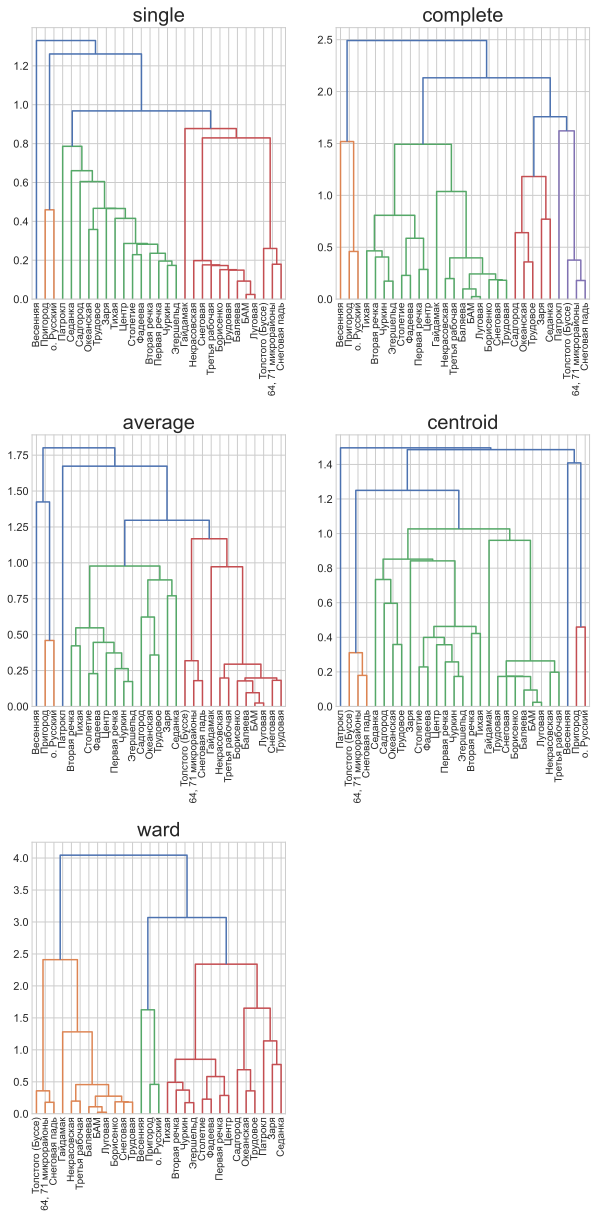

In [35]:
methods = ['single','complete','average','centroid','ward']
plt.figure(figsize=(10,20))
for i in methods:
        plt.subplot(3, 2, methods.index(i)+1)
        plt.subplots_adjust(hspace=0.5)
        create_dendrogram(data_pca, method=i)
plt.show()

Построены дендрограммы с помощью функции create_dendrogram для методов ближнего соседа, дальнего соседа, средней связи, Варда и центроидного. Как видно из рисунков 1–5  независимо от способа измерения расстояния между кластерами составы кластеров получаются одинаковыми. В зависимости от того на каком расстоянии между кластерами мы проведем разбиение получается от одного до одиннадцати кластеров. Из рисунков явно видны разбиения на три и пять кластеров. 



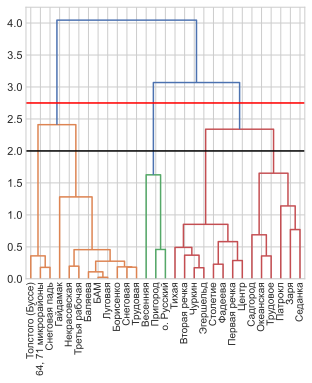

In [12]:
plt.figure(figsize=(5,5))
create_dendrogram(data_pca, method='ward')
plt.hlines(2, 0, 1000000, color='black')
plt.hlines(2.75, 0, 1000000, color='red')
plt.title('')
plt.show()

В методе Варда на каждом шаге объединяются такие два кластера, которые приводят к минимальному увеличению внутригрупповой суммы квадратов. Если провести разбиение на кластеры на расстоянии равном 2.0 (черная горизонтальная линия), то можно увидеть 5 четко разделенных кластера. Проведя линию на расстоянии равном, 2.7, мы видим три кластера, причем первый явно можно разбить на два более мелких кластера – первый и второй из таблицы, а третий на 4 и 5.
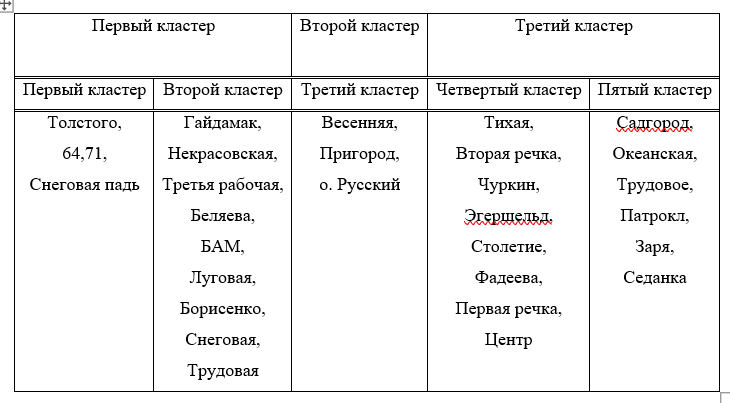

## 3. Кластерный анализ с помощью алгоритма k-means <a class="anchor" id="3"></a>
### 3.1. Выбор оптимального числа кластеров <a class="anchor" id="3.1"></a>

In [13]:
inertias = [] 
sils = [] 
chs = [] 
dbs = [] 
sizes = range(2, 15) 
for k in sizes: 
    k2 = KMeans(random_state=42, n_clusters=k) 
    k2.fit(data_pca) 
    inertias.append(k2.inertia_) 
    sils.append(metrics.silhouette_score(data, k2.labels_))
    chs.append(metrics.calinski_harabasz_score(data, k2.labels_))
    dbs.append(metrics.davies_bouldin_score(data, k2.labels_))
     
table = pd.DataFrame({"Инерция": inertias, 
                      "Коэффициент силуэта": sils, 
                      "Индекс Калински-Харабаса ": chs, 
                      "Индекс Дэвиса-Болдуина": dbs, 
                      "количество кластеров": sizes}).set_index("количество кластеров")
table

,Инерция,Коэффициент силуэта,Индекс Калински-Харабаса,Индекс Дэвиса-Болдуина
количество кластеров,,,,
2,16.304440,0.296100,11.233141,1.321351
3,11.593363,0.335916,11.248425,1.157812
4,8.687261,0.371089,11.219089,0.963087
5,5.999083,0.375809,12.405309,1.039813
6,4.672243,0.376003,12.178437,0.880682
7,3.261507,0.412637,13.815901,0.824256
8,2.433107,0.432386,15.567553,0.663115
9,1.706967,0.392633,16.707969,0.657326
10,1.398004,0.369988,16.106871,0.599357


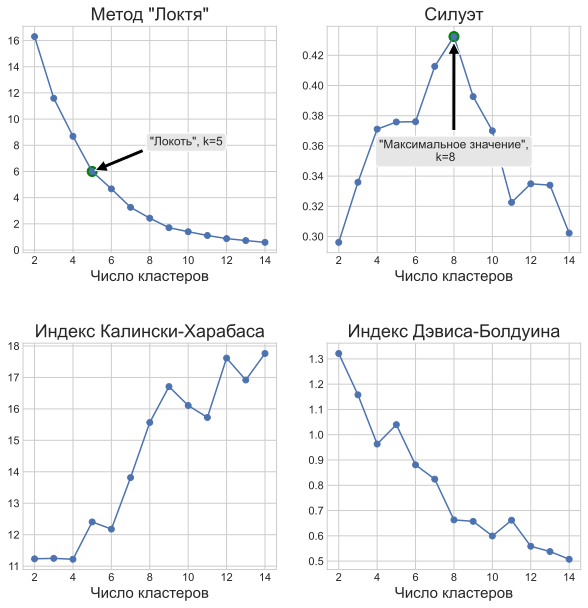

In [14]:
plt.figure(figsize=(10, 10))


plt.subplot(2,2,1)
plt.scatter(5, 5.999083, color='green', s=100, marker='o')
plt.plot(range(2,15,1),inertias,"bo-")
plt.xlabel('Число кластеров',fontsize=15)
plt.title('Метод "Локтя"',fontsize=18)
plt.subplots_adjust(hspace=0.4)
plt.annotate('"Локоть", k=5',(5,5.99),xytext=(8, 8),bbox = dict(boxstyle="round", fc="0.9"),
             arrowprops={'facecolor': 'black','shrink': 0.05})


plt.subplot(2,2,2)
plt.plot(range(2,15,1),sils,"bo-")
plt.scatter(8,0.432386, color='green', s=100, marker='o')
plt.title('Силуэт',fontsize=18)
plt.xlabel('Число кластеров',fontsize=15)
plt.annotate('"Максимальное значение",\n                 k=8',(8, 0.432),xytext=(4.1, 0.35),
             bbox = dict(boxstyle="round", fc="0.9"),
              arrowprops={'facecolor': 'black','shrink': 0.05})

plt.subplot(2,2,3)
plt.plot(range(2,15,1),chs,"bo-")
#plt.scatter(4, 4.99, color='green', s=100, marker='o')
plt.title('Индекс Калински-Харабаса',fontsize=18)
plt.xlabel('Число кластеров',fontsize=15)
#plt.annotate('"Максимальное\n    значение",\n       k=4',(4, 4.97),xytext=(3.6, 4.76),bbox = dict(boxstyle="round", fc="0.9"),
              #arrowprops={'facecolor': 'black','shrink': 0.05})

plt.subplot(2,2,4)
plt.plot(range(2,15,1),dbs,"bo-")
#plt.scatter(5, 0.714933, color='green', s=100, marker='o')
plt.title('Индекс Дэвиcа-Болдуина',fontsize=18)
plt.xlabel('Число кластеров',fontsize=15);

Как видно по графику, `Метод "Локтя"`, функция резко падает при изменении количества кластеров с 2 до 4, а далее спускается плавно. Следовательно, число кластеров равное 4 можно считать оптимальным.

Из графика `Силуэт`, что значение коэффициент силуэта растет до 8 кластеров, максимальное при 8 кластерах, а затем падает, значит  оптимальное число кластеров с 2 до 8.

На графике  `Индекс Калински-Харабаса` видно, что индекс Калински-Харабаса максимален при 14 кластерах, то есть оптимальное число кластеров 14, как и в предыдущих случаях, также 5 кластеров, лучше 4.

`Индекс Дэвиса-Болдуина` не дает однозначного ответа на вопрос об оптимальном количестве кластеров, но из графика на рис. явно видно, что он падает при переходе от трех кластеров к четырем, а значит модель с тремя кластерами хуже разделена, чем с четырьмя. 


### 3.2. Использование алгоритма k-средних <a class="anchor" id="3.2"></a>

Из иерархического анализа и выбора оптимального числа кластеров с помощью метрик и визуализации проведем кластерный анализ для числа кластеров 3 и 5. 

In [15]:
def clustering_kmeans(n_clusters, data, data_first, index='index'):
    model = KMeans(n_clusters=n_clusters,random_state=3)
    model.fit(data)
    dataK=data_first
    dataK['group_no']=model.labels_
    dataK = dataK.reset_index()
    clusters = dataK.groupby('group_no')[index].apply(list)
    mean_data = dataK.groupby('group_no', as_index=True).mean()
    return model.labels_,clusters, dataK, mean_data, model.cluster_centers_

#### `k=3`

In [17]:
labels,clusters,dataK,mean_data,cluster_centers = clustering_kmeans(3,data_pca,df,'districttr')

In [18]:
len(clusters[0])

14

In [19]:
clusters[1]

['64, 71 микрорайоны',
 'БАМ',
 'Баляева',
 'Борисенко',
 'Гайдамак',
 'Луговая',
 'Некрасовская',
 'Снеговая',
 'Снеговая падь',
 'Толстого (Буссе)',
 'Третья рабочая',
 'Трудовая']

In [20]:
clusters[2]

['Весенняя', 'Пригород', 'о. Русский']

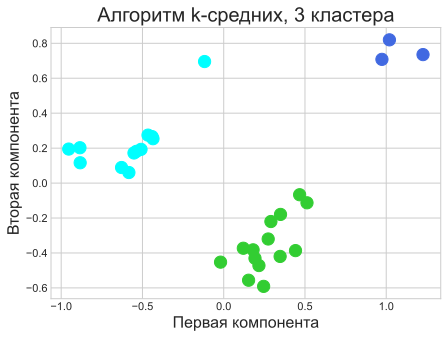

In [21]:
plt.figure(figsize = (7, 5))
plt.scatter(data_pca.values[:, 0], data_pca.values[:, 2], c=dataK['group_no'].map({0:'limegreen',1:'aqua',2:'royalblue',3:'yellow',4:'purple'}), s =150)
plt.xlabel('Первая компонента', fontsize = 16)
plt.ylabel('Вторая компонента', fontsize = 16)
plt.title('Алгоритм k-средних, 3 кластера', fontsize = 20);

In [22]:
mean_data.round().transpose()

group_no,0,1,2
rooms,2.0,2.0,2.0
floor,4.0,5.0,3.0
floors_in_house,9.0,10.0,6.0
building_year,1988.0,1988.0,1993.0
wall_id,12.0,12.0,12.0
dist_centr,9.0,5.0,19.0
keepLabel,2.0,2.0,1.0
balconLabel,1.0,1.0,1.0
bathLabel,1.0,1.0,0.0
priceM,159758.0,155825.0,112889.0


Из рис. 2.8 видно, что первый кластер (зеленый цвет) самый большой, включает в себя 14 элементов, второй кластер – голубой кластер состоит из 12 элементов и третий – синий из трех объектов. Зеленый и голубой кластеры можно попытаться разбить еще на кластеры. Следовательно, целесообразно провести кластерный анализ для числа кластеров 5.

#### `k=5`

In [24]:
labels,clusters,dataK,mean_data,cluster_centers = clustering_kmeans(5,data_pca,df,'districttr')

In [25]:
clusters

group_no
0        [Заря, Океанская, Патрокл, Садгород, Седанка]
1    [БАМ, Баляева, Борисенко, Гайдамак, Луговая, Н...
2                     [Весенняя, Пригород, о. Русский]
3    [Вторая речка, Первая речка, Столетие, Тихая, ...
4    [64, 71 микрорайоны, Снеговая падь, Толстого (...
Name: districttr, dtype: object

In [26]:
print(clusters[0])
print(clusters[1])
print(clusters[2])
print(clusters[3])
print(clusters[4])

['Заря', 'Океанская', 'Патрокл', 'Садгород', 'Седанка']
['БАМ', 'Баляева', 'Борисенко', 'Гайдамак', 'Луговая', 'Некрасовская', 'Снеговая', 'Третья рабочая', 'Трудовая']
['Весенняя', 'Пригород', 'о. Русский']
['Вторая речка', 'Первая речка', 'Столетие', 'Тихая', 'Трудовое', 'Фадеева', 'Центр', 'Чуркин', 'Эгершельд']
['64, 71 микрорайоны', 'Снеговая падь', 'Толстого (Буссе)']


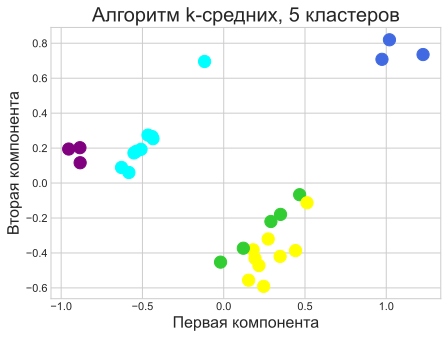

In [27]:
plt.figure(figsize = (7, 5))
plt.scatter(data_pca.values[:, 0], data_pca.values[:, 2], c=dataK['group_no'].map({0:'limegreen',1:'aqua',2:'royalblue',3:'yellow',4:'purple'}), s =150)
plt.xlabel('Первая компонента', fontsize = 16)
plt.ylabel('Вторая компонента', fontsize = 16)
plt.title('Алгоритм k-средних, 5 кластеров', fontsize = 20);

Как и предполагалось голубой кластер распался на два кластера: голубой и фиолетовый, а зеленый на зеленый и желтый. 

In [30]:
df.sort_values('group_no')

,rooms,floor,floors_in_house,building_year,wall_id,dist_centr,keepLabel,balconLabel,bathLabel,priceM,area,sea,group_no
districttr,,,,,,,,,,,,,
Садгород,2.0,2.0,4.0,2016.0,15.0,20,2,1,1.0,142077.0,14.308396,1,0
Заря,2.0,7.5,14.0,2011.0,12.0,8,2,1,1.0,171988.0,1.565328,1,0
Океанская,2.0,5.0,9.0,2009.0,12.0,16,2,1,1.0,137209.0,13.838794,1,0
Патрокл,3.0,4.0,14.0,2016.5,15.0,7,0,1,1.0,181117.0,5.585030,1,0
Седанка,3.0,5.0,10.0,1995.0,14.0,12,1,1,1.0,139738.0,11.638538,1,0
БАМ,2.0,5.0,9.0,1982.0,12.0,6,2,1,1.0,154389.0,4.570670,0,1
Баляева,2.0,4.0,9.0,1981.0,12.0,5,2,1,1.0,150306.0,2.582426,0,1
Борисенко,2.0,4.0,9.0,1985.0,12.0,6,2,1,1.0,132244.0,2.683238,0,1
Трудовая,2.5,3.5,9.0,1970.0,12.0,4,2,1,1.0,123335.5,1.474616,0,1


## `Вывод` <a class="anchor" id="4"></a>

    Самым маленьким по числу микрорайонов, но самым большим по площади является синий кластер, состоящий только из трех микрорайонов. Средняя цена квадратного метра в этих микрорайонах самая низкая по городу, они удалены от центра и имеют морскую границу.
    Еще одним маленьким кластером, но не только по числу микрорайонов, но и по площади является фиолетовый. В него входят небольшие микрорайоны ( в среднем 4 кв км), и не имеющие прибрежной зоны, в основном дома 2013–2017  годов постройки.
    Зеленый кластер занимает третье место по числу микрорайонов (всего 5). Это микрорайоны, имеющие прибрежную зону, удаленные от центра, дома, находящиеся в этих микрорайонах в основном, были построены после 2000-х.
    Микрорайоны голубого кластера граничат друг с другом, находятся в самом сердце Владивостока, не имеют прибрежной границы, старой застройки. Микрорайоны в среднем по 3 м кв.
    Желтый кластер является самым дорогим по цене за кв м, активно застраивающееся микрорайоны


### Расположение 5 кластеров на географической карте Владивостока
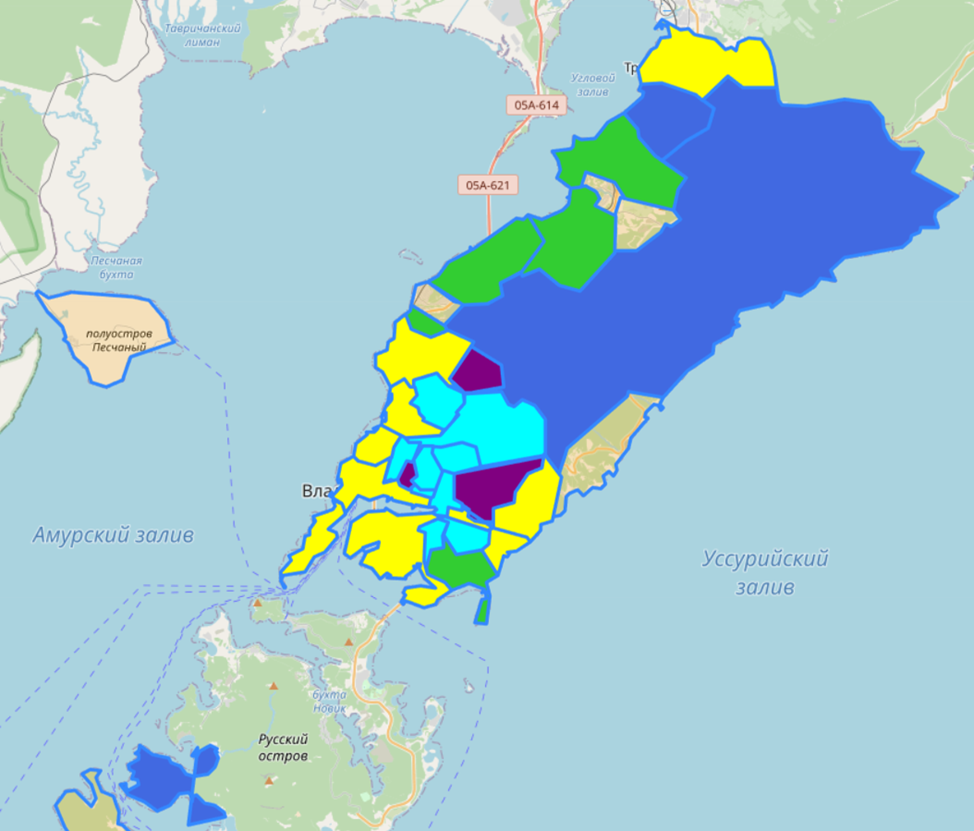